# Title : Classifying Simpsons Chracters Using CNN
## Authors : Danny Kang and Seungin Lyu

## <u>Dataset:</u>
We are using the simpsons chracters dataset from https://www.kaggle.com/alexattia/the-simpsons-characters-dataset.
This is a realatively well-documented dataset except for a few caveats we dicovered during our project.

- number_pic_char.csv is out-dated
- There is an extra simpsons_dataset directory inside simpsons_dataset directory under root. This is a duplicate directory and pyTorch will think it's a seperate class when loading using dataLoader.
- Currently the dataset has 42 unique characters

In [30]:
# import pyTorch, numpy, seaborn, pandas, and etc.

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils import data as D

import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

## Mapping for pyTorch generated labels [0-42] to character names

In [4]:
classes = (
"abraham_grampa_simpson",                                                
"agnes_skinner",                                                         
"apu_nahasapeemapetilon",                                                
"barney_gumble",                                                         
"bart_simpson",                                                          
"carl_carlson",                                                          
"charles_montgomery_burns",                                              
"chief_wiggum",                                                          
"cletus_spuckler",                                                       
"comic_book_guy",                                                        
"disco_stu",                                                             
"edna_krabappel",                                                        
"fat_tony",                                                              
"gil",                                                                   
"groundskeeper_willie",                                                  
"homer_simpson",                                                       
"kent_brockman",                                                         
"krusty_the_clown",                                                      
"lenny_leonard",                                                         
"lionel_hutz",                                                           
"lisa_simpson",                                                          
"maggie_simpson",                                                        
"marge_simpson",                                                         
"martin_prince",                                                         
"mayor_quimby",                                                          
"milhouse_van_houten",                                                   
"miss_hoover",                                                           
"moe_szyslak",                                                           
"ned_flanders",                                                          
"nelson_muntz",                                                          
"otto_mann",                                                             
"patty_bouvier",                                                         
"principal_skinner",                                                     
"professor_john_frink",                                                  
"rainier_wolfcastle",                                                    
"ralph_wiggum",                                                          
"selma_bouvier",                                                         
"sideshow_bob",                                                          
"sideshow_mel",                                                          
"snake_jailbird",                                                        
"troy_mcclure",                                                          
"waylon_smithers"                                                       
)

num_classes = len(classes)
for i,c in enumerate(classes):
  print("classes[%d] : %s"%(i, c))
print("Number of classes : %d"%(num_classes))

classes[0] : abraham_grampa_simpson
classes[1] : agnes_skinner
classes[2] : apu_nahasapeemapetilon
classes[3] : barney_gumble
classes[4] : bart_simpson
classes[5] : carl_carlson
classes[6] : charles_montgomery_burns
classes[7] : chief_wiggum
classes[8] : cletus_spuckler
classes[9] : comic_book_guy
classes[10] : disco_stu
classes[11] : edna_krabappel
classes[12] : fat_tony
classes[13] : gil
classes[14] : groundskeeper_willie
classes[15] : homer_simpson
classes[16] : kent_brockman
classes[17] : krusty_the_clown
classes[18] : lenny_leonard
classes[19] : lionel_hutz
classes[20] : lisa_simpson
classes[21] : maggie_simpson
classes[22] : marge_simpson
classes[23] : martin_prince
classes[24] : mayor_quimby
classes[25] : milhouse_van_houten
classes[26] : miss_hoover
classes[27] : moe_szyslak
classes[28] : ned_flanders
classes[29] : nelson_muntz
classes[30] : otto_mann
classes[31] : patty_bouvier
classes[32] : principal_skinner
classes[33] : professor_john_frink
classes[34] : rainier_wolfcastle


In [5]:
# import dataset

# Resize to 60*60 -> conver to Tensor -> normalize image
transform = transforms.Compose(
    [transforms.Resize((60,60)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the first batch to show as examples
data = dset.ImageFolder(root="./the-simpsons-characters-dataset/characters",transform=transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=18,shuffle=True,num_workers=2)

dataiter = iter(data_loader)
images, labels = dataiter.next()

/Users/danny/Simpsons


In [6]:
# split train/test dataset 50:50

data.len=len(data)
train_len = int(0.5*data.len)
test_len = data.len - train_len
trainset, testset = D.random_split(data, lengths=[train_len, test_len])
print(train_len, test_len)

10466 10467


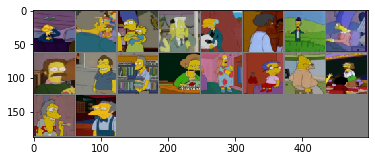

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
# get random images
dataiter = iter(data_loader)
images, labels = dataiter.next()
# print image grid
imshow(torchvision.utils.make_grid(images))

### CNN definition


1. Two hidden convolutional layers (each max pooled with 2*2 with stride 2)
2. Two hidden linear layers
3. One Fully connected linear layer
4. Activation function : RELU


In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)    
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        
        # two hidden linear layers 
        self.fc1 = nn.Linear(in_features=32 * 15 * 15, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=90)
        
        # final feature classification fully connected layer
        self.out = nn.Linear(in_features=90, out_features=42)
        
    def forward(self, x):
        # Start with image size 60x60x3
        
        # first conv layer
        x = self.conv1(x) # ((60-5+4)/1)+1=60 => 60x60x16 
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2) # 30x30x16

        # second conv layer
        x = self.conv2(x) # 30x30x32
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2) # 15x15x32

        # hidden linear layer
        x = x.reshape(-1, 32 * 15 * 15) # 32x15x15
        x = self.fc1(x) # 32x15x15 => Linear => 200
        x = F.relu(x)

        # hidden linear layer
        x = self.fc2(x) # 200 => Linear => 90
        x = F.relu(x)

        # output layer
        x = self.out(x) # 90 => Fully connected => 42

        return x


In [9]:
# function to calculate number of correct labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialize network
network = Network()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(
    trainset
    ,batch_size=500
    ,shuffle=True
)

num_epochs = 100

for epoch in range(num_epochs):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
print('Finished Training')

epoch 0 total_correct: 1317 loss: 66.63178968429565
epoch 1 total_correct: 2921 loss: 55.37170147895813
epoch 2 total_correct: 4110 loss: 47.450151443481445
epoch 3 total_correct: 4762 loss: 42.15468752384186
epoch 4 total_correct: 5272 loss: 37.97292613983154
epoch 5 total_correct: 5797 loss: 34.546010971069336
epoch 6 total_correct: 6194 loss: 31.173153042793274
epoch 7 total_correct: 6639 loss: 27.98606777191162
epoch 8 total_correct: 7002 loss: 25.015877723693848
epoch 9 total_correct: 7420 loss: 21.9662144780159
epoch 10 total_correct: 7768 loss: 19.523054659366608
epoch 11 total_correct: 8080 loss: 17.1008802652359
epoch 12 total_correct: 8372 loss: 14.97105759382248
epoch 13 total_correct: 8740 loss: 12.560033082962036
epoch 14 total_correct: 9027 loss: 10.376103013753891
epoch 15 total_correct: 9374 loss: 8.289228796958923
epoch 16 total_correct: 9580 loss: 6.849567115306854
epoch 17 total_correct: 9722 loss: 5.683263286948204
epoch 18 total_correct: 9809 loss: 4.88820701837539

In [10]:
# save weights to a pth file

PATH = './simpsons.pth'
torch.save(network.state_dict(), PATH)

In [11]:
# load weights to from a previously saved file if you've already trained

PATH = './simpsons.pth'
network = Network()
network.to(device)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
# Test on train set
trainloader = torch.utils.data.DataLoader(trainset, 
                                         batch_size=1000,
                                         shuffle=False)

total_correct = 0
total_images = 0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train images: {1:.2f}%'.format(total_images, model_accuracy))

for i in range(num_classes):
    try:
      print('Accuracy of %30s : %2d%% (%d/%d)' % (classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    except(ZeroDivisionError):
      print('Accuracy of %30s : %d/%d ' % (classes[i], class_correct[i], class_total[i]))

Model accuracy on 10466 train images: 99.98%
Accuracy of         abraham_grampa_simpson : 100% (23/23)
Accuracy of                  agnes_skinner : 100% (1/1)
Accuracy of         apu_nahasapeemapetilon : 100% (11/11)
Accuracy of                  barney_gumble : 100% (1/1)
Accuracy of                   bart_simpson : 100% (30/30)
Accuracy of                   carl_carlson : 100% (2/2)
Accuracy of       charles_montgomery_burns : 100% (19/19)
Accuracy of                   chief_wiggum : 100% (22/22)
Accuracy of                cletus_spuckler : 100% (2/2)
Accuracy of                 comic_book_guy : 100% (12/12)
Accuracy of                      disco_stu : 0/0 
Accuracy of                 edna_krabappel : 100% (8/8)
Accuracy of                       fat_tony : 0/0 
Accuracy of                            gil : 100% (1/1)
Accuracy of           groundskeeper_willie : 100% (3/3)
Accuracy of                  homer_simpson : 100% (49/49)
Accuracy of                  kent_brockman : 100% (6/6)
A

In [29]:
# validation on test images
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1000,
                                         shuffle=False)

total_correct = 0
total_images = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
y_true = torch.tensor([],dtype=torch.long, device=device)
y_pred = torch.tensor([],dtype=torch.long, device=device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true = torch.cat((y_true,labels),0)
        y_pred = torch.cat((y_pred, predicted),0)
        c = (predicted == labels).squeeze()
        for i in range(num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

for i in range(num_classes):
    try:
      print('Accuracy of %30s : %2d%% (%d/%d)' % (classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    except(ZeroDivisionError):
      print('Accuracy of %30s : %d/%d ' % (classes[i], class_correct[i], class_total[i]))

[[308   0   2 ...   0   0   2]
 [  1   7   0 ...   0   0   0]
 [  1   0 243 ...   0   0   0]
 ...
 [  0   0   1 ...   8   0   0]
 [  1   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0  38]]
Model accuracy on 10467 test images: 67.99%
Accuracy of         abraham_grampa_simpson : 68% (15/22)
Accuracy of                  agnes_skinner : 100% (1/1)
Accuracy of         apu_nahasapeemapetilon : 81% (9/11)
Accuracy of                  barney_gumble : 50% (2/4)
Accuracy of                   bart_simpson : 60% (20/33)
Accuracy of                   carl_carlson : 66% (2/3)
Accuracy of       charles_montgomery_burns : 56% (14/25)
Accuracy of                   chief_wiggum : 74% (20/27)
Accuracy of                cletus_spuckler : 0/0 
Accuracy of                 comic_book_guy : 70% (7/10)
Accuracy of                      disco_stu : 0/0 
Accuracy of                 edna_krabappel : 60% (6/10)
Accuracy of                       fat_tony : 0/0 
Accuracy of                            gil :  0% (0/

### Analysis of model using a confusion matrix

We got a 68% accuracy on the test set for 42 classes! Not bad.
Our instinct was that we can bump up the accuracy by removing some of the classes that have less than 100 images for the training data. To validate our assumption, we created a confusion matrix.
We found some interesting traits :

- Abraham_grampa_simpson has most confusions with homer_simpson.
- Bart_simpson has a significant number of confusions with lisa_simpson.
- Homer_simpson seem to be getting confused with numerous characters.
- Maggie_simpson has most confusions with bar_simpson
- For some of the unpopular characters(in terms of number of picture) like gil, groundskeeper_willie, it is hard to tell if the model is classifying accruately due to small number of dataset.

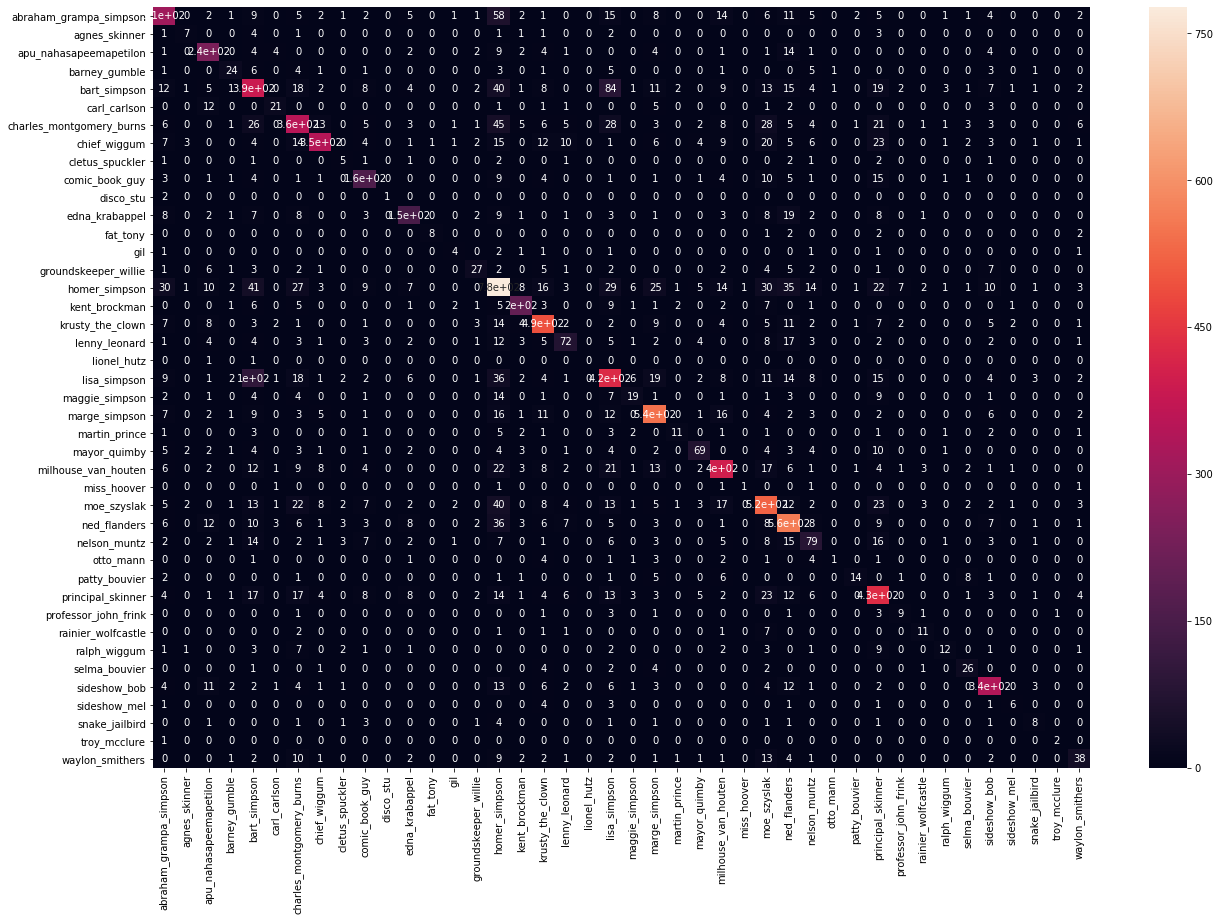

In [35]:
# Before reducing dataset
ctable = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(ctable, index = [classes[i] for i in range(num_classes)], 
                     columns = [classes[i] for i in range(num_classes)])
plt.figure(figsize = (21,14))
sn.heatmap(df_cm, annot=True)

#### Tweak : What if we remove the unpopular characters?

By running a python script (count_images.py), we elimnated characters that have less than 100 images from the dataset. Then we retrained the model. We redefined the mappings for 25 chracters.

In [3]:
new_classes = (
"abraham_grampa_simpson",                                                                                                   
"apu_nahasapeemapetilon",                                                
"barney_gumble",                                                         
"bart_simpson",                                                                                                              
"charles_montgomery_burns",                                              
"chief_wiggum",                                                                                                         
"comic_book_guy",                                                                                                        
"edna_krabappel",                                                                                                              
"groundskeeper_willie",                                                  
"homer_simpson",                                                       
"kent_brockman",                                                         
"krusty_the_clown",                                                      
"lenny_leonard",                                                                                                             
"lisa_simpson",                                                          
"maggie_simpson",                                                        
"marge_simpson",                                                                                    
"mayor_quimby",                                                          
"milhouse_van_houten",                                                                                  
"moe_szyslak",                                                           
"ned_flanders",                                                          
"nelson_muntz",                                                                                                                                                             
"principal_skinner",                                                                                                                                                                                                    
"selma_bouvier",                                                         
"sideshow_bob",                                                                                                                                                                                                                         
"waylon_smithers"                                                       
)
new_num_classes = len(new_classes)
print(new_num_classes)

25


In [39]:
# image folders with less than 100 images are left out

new_data = dset.ImageFolder(root="./the-simpsons-characters-dataset/characters_reduced",transform=transform)
data_loader = torch.utils.data.DataLoader(new_data, batch_size=18,shuffle=True,num_workers=2)

data.len=len(data)
train_len = int(0.5*data.len)
test_len = data.len - train_len
trainset, testset = D.random_split(data, lengths=[train_len, test_len])
print(train_len, test_len)

In [44]:
# train our model with reduced dataset
network = Network()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(
    trainset
    ,batch_size=500
    ,shuffle=True
)

num_epochs = 100

for epoch in range(num_epochs):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
print('Finished Training')

epoch 0 total_correct: 1268 loss: 64.90659260749817
epoch 1 total_correct: 2842 loss: 52.48996305465698
epoch 2 total_correct: 3876 loss: 45.34665632247925
epoch 3 total_correct: 4696 loss: 39.63024926185608
epoch 4 total_correct: 5247 loss: 35.48991847038269
epoch 5 total_correct: 5682 loss: 32.0030837059021
epoch 6 total_correct: 6138 loss: 29.508315682411194
epoch 7 total_correct: 6458 loss: 26.334193229675293
epoch 8 total_correct: 6787 loss: 24.06558930873871
epoch 9 total_correct: 7120 loss: 21.663841009140015
epoch 10 total_correct: 7413 loss: 19.37595236301422
epoch 11 total_correct: 7705 loss: 17.219811975955963
epoch 12 total_correct: 8061 loss: 14.823384702205658
epoch 13 total_correct: 8328 loss: 13.049139857292175
epoch 14 total_correct: 8550 loss: 11.26671576499939
epoch 15 total_correct: 8663 loss: 10.278300195932388
epoch 16 total_correct: 9033 loss: 7.89932319521904
epoch 17 total_correct: 9213 loss: 6.649237960577011
epoch 18 total_correct: 9447 loss: 5.25603006780147

In [45]:
# save weights to a pth file

PATH = './reduced_simpsons.pth'
torch.save(network.state_dict(), PATH)

In [46]:
# load weights to from a previously saved file if you've already trained

network = Network()
network.to(device)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [53]:
# Test on train set (reduced dataset)
trainloader = torch.utils.data.DataLoader(trainset, 
                                         batch_size=1000,
                                         shuffle=False)

total_correct = 0
total_images = 0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = new_network(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(new_num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train images: {1:.2f}%'.format(total_images, model_accuracy))

for i in range(new_num_classes):
    try:
      print('Accuracy of %30s : %2d%% (%d/%d)' % (new_classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    except(ZeroDivisionError):
      print('Accuracy of %30s : %d/%d ' % (new_classes[i], class_correct[i], class_total[i]))

Model accuracy on 10093 train images: 100.00%
Accuracy of         abraham_grampa_simpson : 100% (20/20)
Accuracy of         apu_nahasapeemapetilon : 100% (9/9)
Accuracy of                  barney_gumble : 100% (3/3)
Accuracy of                   bart_simpson : 100% (16/16)
Accuracy of       charles_montgomery_burns : 100% (11/11)
Accuracy of                   chief_wiggum : 100% (11/11)
Accuracy of                 comic_book_guy : 100% (4/4)
Accuracy of                 edna_krabappel : 100% (2/2)
Accuracy of           groundskeeper_willie : 100% (2/2)
Accuracy of                  homer_simpson : 100% (35/35)
Accuracy of                  kent_brockman : 100% (5/5)
Accuracy of               krusty_the_clown : 100% (18/18)
Accuracy of                  lenny_leonard : 100% (3/3)
Accuracy of                   lisa_simpson : 100% (26/26)
Accuracy of                 maggie_simpson : 100% (4/4)
Accuracy of                  marge_simpson : 100% (21/21)
Accuracy of                   mayor_quimby

In [58]:
# validation on test images (reduced dataset)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1000,
                                         shuffle=False)

total_correct = 0
total_images = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
y_true_reduced = torch.tensor([],dtype=torch.long, device=device)
y_pred_reduced = torch.tensor([],dtype=torch.long, device=device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true_reduced = torch.cat((y_true_reduced,labels),0)
        y_pred_reduced = torch.cat((y_pred_reduced, predicted),0)
        c = (predicted == labels).squeeze()
        for i in range(new_num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

for i in range(new_num_classes):
    try:
      print('Accuracy of %30s : %2d%% (%d/%d)' % (new_classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    except(ZeroDivisionError):
      print('Accuracy of %30s : %d/%d ' % (new_classes[i], class_correct[i], class_total[i]))

Model accuracy on 10094 test images: 68.01%
Accuracy of         abraham_grampa_simpson : 46% (7/15)
Accuracy of         apu_nahasapeemapetilon : 66% (4/6)
Accuracy of                  barney_gumble :  0% (0/1)
Accuracy of                   bart_simpson : 44% (8/18)
Accuracy of       charles_montgomery_burns : 69% (9/13)
Accuracy of                   chief_wiggum : 66% (6/9)
Accuracy of                 comic_book_guy : 50% (3/6)
Accuracy of                 edna_krabappel : 44% (4/9)
Accuracy of           groundskeeper_willie : 33% (1/3)
Accuracy of                  homer_simpson : 51% (15/29)
Accuracy of                  kent_brockman : 66% (2/3)
Accuracy of               krusty_the_clown : 57% (11/19)
Accuracy of                  lenny_leonard : 80% (4/5)
Accuracy of                   lisa_simpson : 87% (14/16)
Accuracy of                 maggie_simpson :  0% (0/3)
Accuracy of                  marge_simpson : 58% (7/12)
Accuracy of                   mayor_quimby : 66% (2/3)
Accuracy of

#### Result : No difference accuracy on test images

We did end up removing about 400 images, but this removal of unpopular characters did not have a significant impact on the final accuracy. We still observe the similar patterns as in the previous model with all the characters.
The only changes is that the confusion matrix is easier to read, but we do we a colored diagonal line accross the matrix which illustrates that our model is working to an exten.

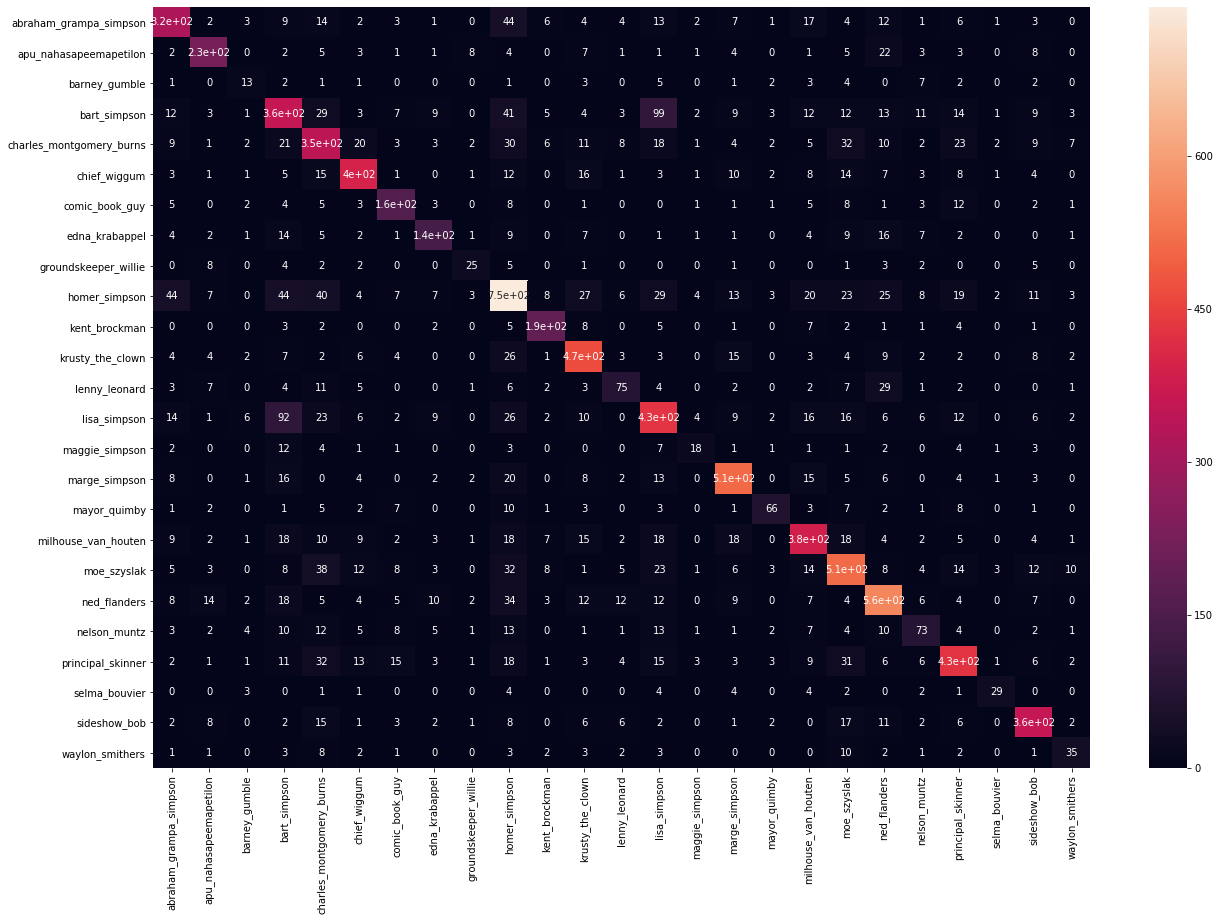

In [59]:
# After reducing dataset
new_ctable = confusion_matrix(y_true_reduced, y_pred_reduced)
new_df_cm = pd.DataFrame(new_ctable, index = [new_classes[i] for i in range(new_num_classes)], 
                     columns = [new_classes[i] for i in range(new_num_classes)])
plt.figure(figsize = (21,14))
sn.heatmap(new_df_cm, annot=True)

### Classify your own picture!

use this cell to classify your own picture. Note that using drawings/pictures in a different style than the original Simpsons animation will not be accurate.

In [119]:
# predict random images

path = "./the-simpsons-characters-dataset/drawings"

def make_guess(img_path):
    drawn_test_set = torchvision.datasets.ImageFolder(root=img_path, transform=transform)
    drawn_data_loader = torch.utils.data.DataLoader(drawn_test_set, batch_size=18,shuffle=True,num_workers=2)

    with torch.no_grad():
        for data in drawn_data_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            for i, a in enumerate(predicted):
                idx = torch.IntTensor.item(a)
                print("Picture %s : %s" %(i,new_classes[idx]))

make_guess(path)

Picture 0 : homer_simpson
